# **10.2 Epipolar geometry**

Epipolar geometry is the **set of geometric constraints between two views of a scene**. When two cameras capture a 3D scene from two different positions, there is a number of geometric relations between the 3D points and their projections onto the 2D images that lead to constraints between the image points. These relations are derived based on the assumption that the cameras can be approximated by the pinhole camera model (e.g. their images are undistorted). $\\[10pt]$

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/epipolar.png" width="500" /></center>$\\[10pt]$

In this notebook, we will practice with:

- Epipolar geometry
- Stereo rectification
- Fundamental matrix

**This notebook contains <font color=green>2 assignments</font>**



## **Problem context - Stereo rectification**

In practice, as we depicted in the previous notebook, accurate triangulation is not fully feasible as **stereo systems do not fulfill the ideal configuration**, but the good news is that any two images taken with any configuration (as long as there is overlap between the images, of course) can be transformed so that they comply with an ideal stereo camera configuration. This is called **stereo rectification** or **image rectification**. Here, we apply homographies to the left and right images in order to force this ideal configuration.$\\[10pt]$

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/rectification.png" width="600" /></center>

Image rectification is based in epipolar geometry so, let's start to learn how it works!

In [9]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

images_path = '/gdrive/My Drive/Colab Notebooks/Chapter 10. Stereo vision/images/'

import sys
sys.path.append("/gdrive/My Drive/Colab Notebooks/Chapter 10. Stereo vision/utils")
from drawlines1 import drawlines

## **10.2.1 Concepts of epipolar geometry**

This a summary of the main concepts reagarding eipolar geometry you have learnt during the course:

- **Epipolar plane**: It is formed by 3 points: the left and right optical centers ($C_l,\ C_r$), and a 3D point in the world ($\mathbf{X}$).
- **Epipolar lines**: Intersections between the epipolar plane and the image planes. The 2D projections $(x_l, x_r)$ of the 3D point $\mathbf{X}$ lie on their corresponding epipolar lines. They are useful to find corresponding points.
- **Epipoles**: Intersection point of all epipolar lines. It is the projection of the optical center of each camera on the other image plane.

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/epipolar1.png" width="600" /></center>

For a pair of cameras with parallel optical axis (ideal configuration), the epipolar lines are horizontal and parallel in the images, while the epipoles are at the infinity.

<table>
    <tr>
        <td><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/epipolar3.png" width="560" /></td>
        <td><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/epipoles_inf.png" width="600" /></td>
    </tr>
</table>



## **10.2.2 Stereo rectification**

In practice, our camera configuration will not be ideal and this involves a difficulty to **find the correspondences and to perform stereo triangulation**:

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/non-rectified.png" width="400" /></center>

As you can see in the images, **the epipolar lines are not horizontal** as in the ideal configuration, but this can be solved. The process of **stereo rectification** projects the images on a common plane so that the epipolar lines become horizontal in both images and at the same height, that is, transform them as if they had been captured in an ideal configuration, taking the **epipoles to infinity**.

For that, we can compute a **homography for each camera** that transforms the images to such ideal configuration:

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/rectified.png" width="400" /></center>

#### <font color="orange">**OpenCV tip**</font>

OpenCV defines a method called [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052), which returns the **rectification homographies** for both images given a set of matching points and the **fundamental matrix**. This method is used when **you don't know the relative pose of the cameras** that captured the pictures (e.g. two images taken with the same camera but in different positions).



## **10.2.3 Essential and Fundamental Matrices**

Recall from the course slides that there are two matrices that relate corresponding points between two images:
- **Essential matrix**: relates a point on an image and the epipolar line that contains its corresponding point on the other image. However, in order to get the points coordinates in pixels, we need the camera to be calibrated, and that is, generally, inconvenient.
- **Fundamental matrix**: It is similar to the Essential Matrix, but it works in the image plane instead of with sensor coordinates. This is what we are going to use in this notebook:

The **Fundamental matrix is the cornerstone of the epipolar geometry**, as it relates points and their corresponding epipolar lines in these ways:

### **F relating two corresponding points:**
We can check if a correspondence of points is valid (points are contained in corresponding epipolar lines):

$$\mathbf{\tilde{x}}'^\texttt{T}_l \mathbf{F} \mathbf{\tilde{x}}'_r = 0$$

### **F relating points with their epipolar lines:**
It's also possible to find the corresponding epipolar line of a point:

$$\mathbf{l}'_l = \mathbf{F} \mathbf{\tilde{x}}'_r \quad \mathbf{l}'_r = \mathbf{F}^\texttt{T} \mathbf{\tilde{x}}'_l$$

### **F used to compute the epipoles:**
As the epipole is the intersection point of all epipolar lines, the epipole is the null space of the Fundamental matrix:

$$
\begin{eqnarray}
    \mathbf{\tilde{x}}'^\texttt{T}_l \mathbf{F} \mathbf{\tilde{e}}'_r & = & 0,  \quad \forall \mathbf{\tilde{x}}'_l\\
    \mathbf{F} \mathbf{\tilde{e}}'_r & = & \mathbf{F}^\texttt{T} \mathbf{\tilde{e}}'_l = 0
\end{eqnarray}
$$

### **BONUS: F used to feel the rhythm:**
The Fundamental matrix is so popular in computer vision that it even has a [funny song](https://www.youtube.com/watch?v=DgGV3l82NTk)!

## **10.2.4 Coding**

Let's play a little bit with these concepts by programming some snippets of code. We are going to rectify a pair of images, draw some epipolar lines and find the fundamental matrix between the views!

### **<font color="green"><b>ASSIGNMENT #1a: Get F</b></font>**

In this task, we are going to rectify two images using the above-mentioned method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052). For that, take two images of the same scene from different positions, imitating a stereo system.

> <font color="orange"><b>Note:</b> You can use the images `im0.png` (left) and `im1.png` (right) provided to you with this notebook if you can't use your own images.</font>

The first step for image rectification is **finding the Fundamental Matrix**, and for this we need a set of matching points! Use your favourite keypoint detector + descriptor in order to get a proper set of matches (we recommend **ORB for big images**).

OpenCV already implements a method for computing the Fundamental Matrix ([cv2.findFundamentalMat](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#gae420abc34eaa03d0c6a67359609d8429)) from two lists of matching points (unfortunately using their coordinates, not `cv2.keyPoint()` objects, check the documentation). Apart from the Fundamental Matrix, this method also returns a vector `mask`, which states the points used for the matrix calculation.
> <font color="orange"><b>Note:</b> : Use `CV_FM_RANSAC` as the `method` parameter to mitigate the effect of outliers. A value of 1 and 0.99 for the `ransacReprojThreshold` and `confidence` parameters, respectively, are good choices.</font>

**What to do?**
- Load the images.
- Detect and match ORB keypoints using a BF matcher.
- Plot the matches using `cv2.drawMatches`.
- Create two lists of corresponding points (each one of size $N\times2$) as inputs for the Fundamental Matrix method. You will need to convert the lists to arrays (use `np.asarray`).
- Compute the Fundamental Matrix that defines the epipolar geometry between your images and print it.

In [11]:
image_name1 = "im0.png" # moto
image_name2 = "im1.png" # moto

# ASSIGNMENT 1a
# Write your code here!
points1=[]
points2=[]
imagel = cv2.imread(images_path + 'im0.png', -1)
imagel = cv2.cvtColor(imagel, cv2.COLOR_BGR2RGB)
imagel_gray=cv2.cvtColor(imagel, cv2.COLOR_RGB2GRAY)

imager= cv2.imread(images_path + 'im1.png', -1)
imager=cv2.cvtColor(imager, cv2.COLOR_BGR2RGB)
imager_gray=cv2.cvtColor(imager, cv2.COLOR_RGB2GRAY)


# Initiate STAR detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp_l = orb.detect(imagel,None)
kp_r = orb.detect(imager,None)
# compute the descriptors with ORB
kp_l, des_l = orb.compute(imagel, kp_l)
kp_r, des_r = orb.compute(imager, kp_r)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_l, des_r)
matches = sorted(matches, key=lambda x:x.distance)

for n in range(len(matches)):
    coord_l = matches[n].queryIdx
    coord_r = matches[n].trainIdx
    points1.append(kp_l[coord_l].pt)
    points2.append(kp_r[coord_r].pt)
FMatrix, mask=cv2.findFundamentalMat(np.asarray([points1]), np.asarray([points2]))
print(FMatrix)

[[ 2.14729816e-09 -7.47631741e-06  3.40658125e-03]
 [ 7.95292824e-06 -9.96295123e-08  8.68699833e-02]
 [-3.60162944e-03 -8.91027608e-02  1.00000000e+00]]


####<font color=red><b>Expected output</b></font>
Number of ORB matches = 202

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/ch102_a1a_result.png" width="1000" align="left"/>
</center>

Fundamental matrix =

    [[ 4.61075405e-09 -8.46117319e-06  4.24132947e-03]
    [  8.85226015e-06 -1.04865920e-06 -3.25004994e-01]
    [ -4.62069358e-03  3.24051122e-01  1.00000000e+00]]

Result obtained with:

**`cv2.findFundamentalMat(pts_l, pts_r, cv2.FM_RANSAC, 1.0, 0.99)`**

#### <font color="blue"><b>Discussion #1</b></font>

- Do you think that the matches are correct?

  <font color=blue><b>Your answer here!</b></font>

### **<font color="green"><b>ASSIGNMENT #1b: Rectification</b></font>**

Now, we can **compute the homographies** needed to rectify the images with the method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052), which takes as input:
- **the lists of matching points** used in the previous method (but only those marked as inliers for the `findFundamentalMat` method!)
- **the Fundamental matrix**,
- and **the shape of the images**.

and returns the computed homographies. Once you have them, you already know how to apply an homography to an image, right? Well, then do it!

**What to do?**
- Filter out the outliers from the lists of matching points.
- Compute the rectification homographies and print them.
- Apply the homographies to rectify your images
- Display the rectified images.

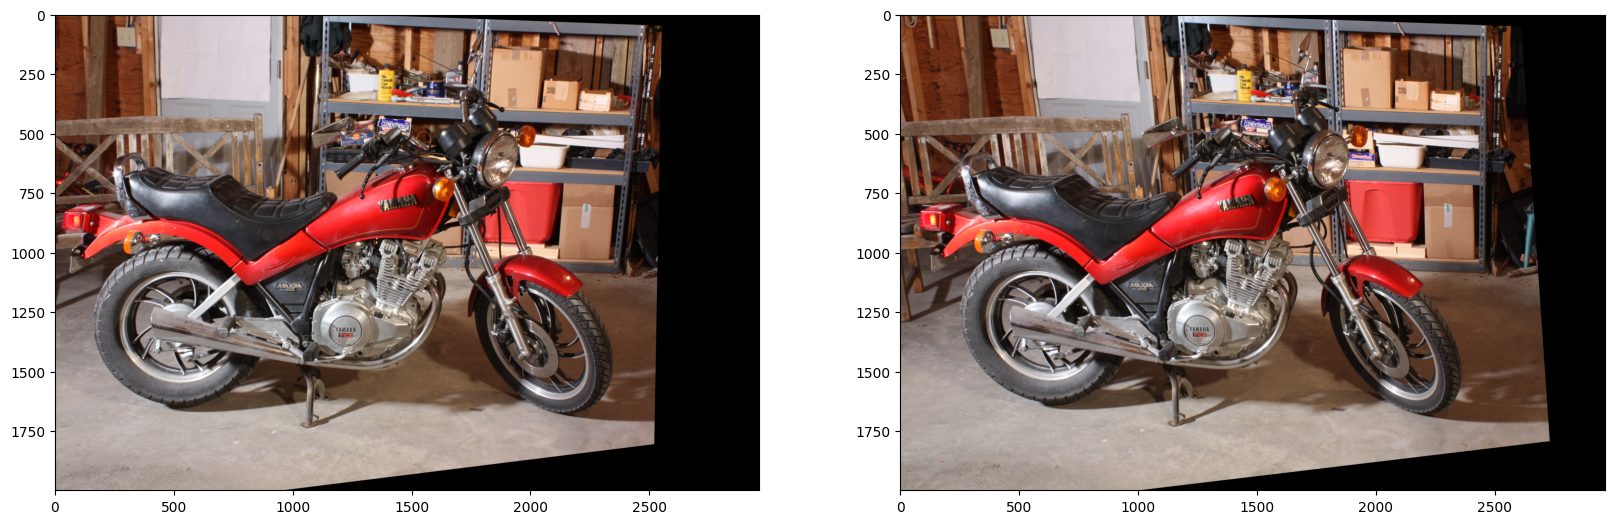

In [12]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

# ASSIGNMENT 1b
# Write your code here!
retval, h1, h2=cv2.stereoRectifyUncalibrated(np.asarray([points1]), np.asarray([points2]), FMatrix, (imagel.shape[0], imager.shape[1]))

imagel_trans=cv2.warpPerspective(imagel,h1,(imagel.shape[1],imagel.shape[0]))
plt.subplot(121)
plt.imshow(imagel_trans)

imager_trans=cv2.warpPerspective(imager,h2,(imagel.shape[1],imagel.shape[0]))
plt.subplot(122)
plt.imshow(imager_trans)

####<font color=red><b>Expected output</b></font>

Number of inliers = 112 out of 202

$H_l = $
    
    [[-3.19237054e-01  4.61255909e-02  9.22145317e+00]
    [  4.73434102e-03 -3.24319128e-01 -5.03979655e+00]
    [  9.08460813e-06 -1.30467999e-06 -3.33416382e-01]]

$H_r = $

    [[ 9.72817026e-01 -2.56012832e-02  6.51240759e+01]
    [ -1.34647032e-02  1.00070057e+00  1.24264601e+01]
    [ -2.68368710e-05  7.06256486e-07  1.02579020e+00]]

Rectified images:

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/ch102_a1b_result.png" width="1000" align="left"/>
</center>

### **<font color="green"><b>ASSIGNMENT #1c: Validating the rectification</b></font>**

Now, we are going to check if, after the rectification, the corresponding points fall in the same row.

For that:
- Plot the images side-by-side (use `np.concatenate`)
- Plot the left keypoints in the left part of the image and a horizontal line at the same row in the right part of the image.

> <font color="orange"><b>Note:</b> Remember that the images are now rectified but the keypoints have their coordinates referred to the original, non-rectified, image. So you will need to get the coordinates of the keypoints in the rectified image...</font>

In [29]:
# ASSIGNMENT #1c
# Write your code here!
image_conc = np.concatenate((imagel_trans, imager_trans), axis=1)lines=cv2.computeCorrespondEpilines(np.asarray([points2]), 2, FMatrix)





SyntaxError: ignored

####<font color=red><b>Expected output</b></font>

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/ch102_a1c_result.png" width="1000" align="left"/>
</center>

### **<font color="green"><b>ASSIGNMENT #2a: Epipolar geometry</b></font>**

Having the Fundamental matrix, **we can also calculate the epipolar lines** that correspond to any point, **even if the images are not rectified**. Remember that the Fundamental matrix encompasses the intrinsic geometric information between two views, regardless the scene!. The OpenCV's method [cv2.computeCorrespondEpilines](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga19e3401c94c44b47c229be6e51d158b7) facilitates this, having as inputs:

- `points`: set of $N$ input points of which corresponding epipolar lines will be computed
- `whichImage`: index of the image (1 for left or 2 for right) that contains the points
- `F`: the Fundamental matrix

It returns the **coefficients of the epipolar lines** in a ($N \times 1 \times 3$) matrix.

To show the epipolar lines, we have provided to you a method called `drawlines` (in utils) that plots the epilines in one image, and their corresponding keypoints (with the same color) in the other image, its inputs are:

- `im_points`: input image in which the points are going to be drawn.
- `pts`: array containing the points' coordinates ($N \times 2$) of `im_points`.
- `im_lines`: input image in which the epipolar lines are going to be drawn.
- `lines`: coefficients of the epipolar lines drawn in `im_lines` ($N \times 3$, use `lines.reshape(-1,3)` to convert from $N \times 1 \times 3$ to $N \times 3$).
- `size`: size of the elements drawn (default 5). Change this if you cannot see the lines and points or they are too big.

It returns two images, `im_lines` (with the lines superimposed) and `im_points` (where the points have been drawn).

**What to do?**
- Determine the epipolar lines of the keypoints previously detected in the right image.
- Draw the epipolar lines in the left image and the points in the right one.
- Finally, display both images.

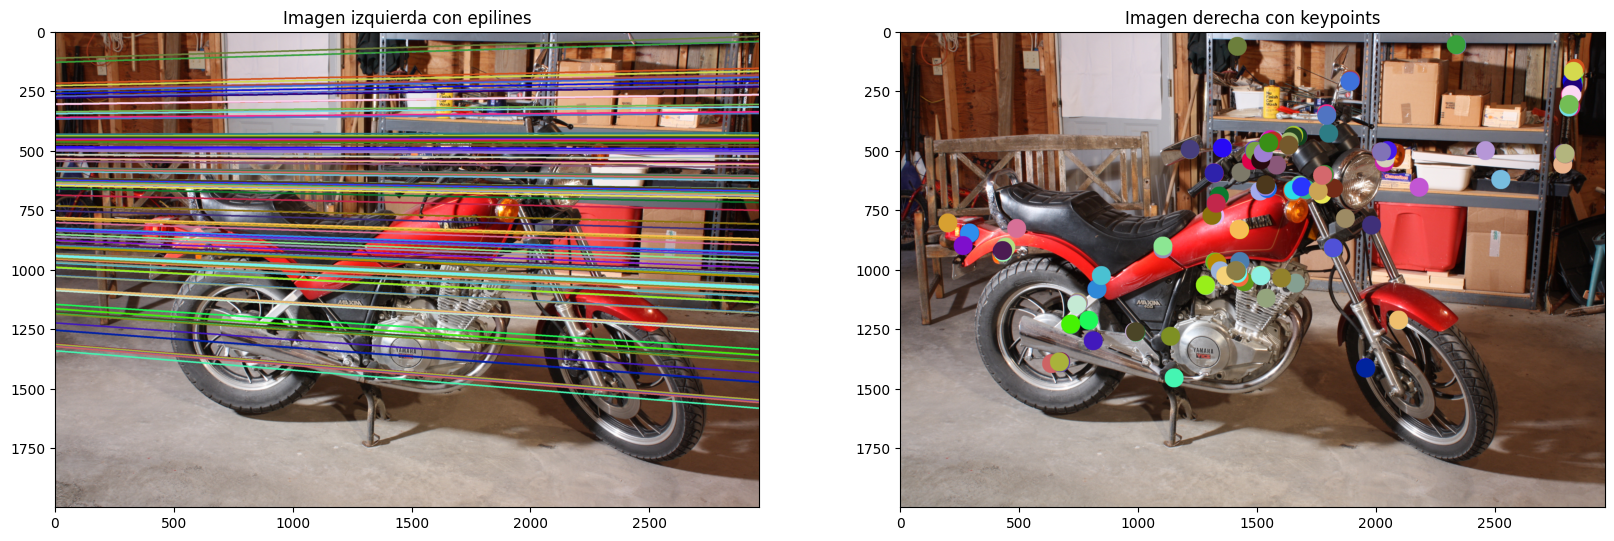

In [14]:
# ASSIGNMENT #2a
# Write your code here!
lines=cv2.computeCorrespondEpilines(np.asarray([points2]), 2, FMatrix)

imagel_new, imager_new = drawlines(imager.copy(), np.asarray(points2, dtype = np.uint), imagel.copy(), lines, size = 5)

plt.subplot(1,2,1)
plt.title("Left image with epipolar lines")
plt.imshow(imagel_new)

plt.subplot(1,2,2)
plt.title("Right image with keypoints")
plt.imshow(imager_new)


####<font color=red><b>Expected output</b></font>

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/ch102_a2a_result.png" width="1000" align="left"/>
</center>

### <font color="green"><b>ASSIGNMENT #2b: Matching using the epipolar constraint</b></font>

Finally, we are going to use the epipolar lines to refine the keypoint matching process. If you remember, this is something you already did in previous chapters when you matched keypoints by looking for them in the same row of the image. At that point you did not know that you were using the epipolar constraint for an ideal camera setup (or rectified images).

Now you are using it in the original images, without rectifying them.

For that, we provide a pair of methods:
- **`point_line_distance`**: To compute the distance between a line and a point.
- **`hamming_distance`**: To compute the bitwise Hamming distance between descriptors.


In [15]:
from math import sqrt
def point_line_distance(point, line):
  return abs((line[0] * point[0] + line[1] * point[1] + line[2])) / (sqrt(line[0]**2 + line[1]**2))

def hamming_distance(a, b):
    r = (1 << np.arange(8))[:,None]
    return np.count_nonzero((np.bitwise_xor(a,b) & r) != 0)

Now, use them to perform this:
- For each keypoint in the **right** image:
  - Compute the distance between its corresponding epipolar line and each keypoint in the left image.
  - If this image distance is below a threshold (e.g. 2px), then compute the descriptor distance between the involved keypoints.
  - If this descriptor distance is below a threshold (e.g. 70), then add it to a list of matches (use `cv2.DMatch` if you want).
- Plot the matched pairs in the original images with the same colors.

> <font color="orange"><b>Notes:</b>
- In the loops, you can use a combination of `enumerate` and `zip` to get elements from several vectors at the same time, as well as the index of the loop. Have a look to [this](https://note.nkmk.me/en/python-for-enumerate-zip/).
- Convert the original images to GRAY and back to RGB in order to draw on them in color while keeping the image in GRAY. This will allow you to see the points better (check the expected output).
</font>

In [16]:
# Assignment #2b
# Write your code here!

####<font color=red><b>Expected output</b></font>

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/ch102_a2b_result.png" width="1000" align="left"/>
</center>

#### <font color="blue"><b>Discussion #2</b></font>
Compare the results with the BruteForce matching output you got before computing the Fundamental Matrix.

- What benefits does this way of matching involve?

  <font color=blue><b>Your answer here!</b></font>

- Do you think that this method is faster than using *brute force*?

  <font color=blue><b>Your answer here!</b></font>

- Is there a detector/descriptor that could benefit more from this approach? Or all of them equally?

  <font color=blue><b>Your answer here!</b></font>


## **Conclusion**

Brilliant! Remember that if we had a fixed stereo system, **the Fundamental matrix will be constant for any pair of images**. Anyway, once rectification has been applied, triangulation is more precise, and so would be the depth computation!

In this notebook, we have learnt:

- the fundamentals of epipolar geometry
- how to perform stereo rectification for uncalibrated and calibrated cameras
- how to find the Fundamental matrix from a pair of images